# Weak Supervision With Trees

In the notebook `demos/weak_supervision.ipynb` we have seen that a neural network (NN) classifier trained to distinguish a signal+background sample from a background-only one will also learn to distinguish signal from background directly. We call this (unrealistic) case where we have a perfect background-only dataset an *idealized anomaly detector* (IAD), as it is an idealization of anomaly detection approaches, such as [CWoLa Hunting](https://arxiv.org/abs/1902.02634) and [CATHODE](https://arxiv.org/abs/2109.00546) where we obtain this background sample in a data-driven way. I.e. any challenges that we face with an IAD will very likely apply to weakly supervised anomaly detection methods in general.

We will explore one such challenge in this notebook: the **sensitivity loss due to uninformative features**. In order to be sensitive to a broad range of anomalies (thus being maximally model agnostic), we would ideally add as many input features to the classifier as possible. For a specific type of signal, most of these features would then be uninformative. Unfortunately, it turns out in practice that this heavily decreases the sensitivity to that signal. The presence of a small signal within an overwhelming background is more and more washed out in more and more noisy dimensions, making it much harder to detect for the NN. This challenge was discussed in more depth in [this paper](https://arxiv.org/abs/2309.13111), where a substantial improvement was achieved by **replacing the NN classifier by a boosted decision tree (BDT) classifier**. The very different inductive bias of tree-based classifiers makes them more resilient to noisy features.

This notebook builds on `demos/weak_supervision.ipynb`, using the same dataset and the same NN classifier. We will then train a [Histogram-based Gradient Boosting Classification Tree](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) as an alternative to confirm it has similar performance as the NN when all features contain relevant information on the specific kind of signal that is present in the data. Then we will add ten uninformative features, simply by drawing random numbers from a normal distribution, and see how the two classifier models react differently. [The tree-based weak supervision paper](https://arxiv.org/abs/2309.13111) also discussed that the BDTs become even more stable at high amounts of noise if we *ensemble* them: train multiple BDTs with different train/validation splits and average their predictions. Thus, we will end the notebook with an implementation of such an emsemble model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys

from os.path import exists, join, dirname, realpath
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# adding parent directory to path
parent_dir = dirname(realpath(globals()["_dh"][0]))
sys.path.append(parent_dir)

from sk_cathode.classifier_models.boosted_decision_tree import HGBClassifier
from sk_cathode.classifier_models.neural_network_classifier import NeuralNetworkClassifier
from sk_cathode.utils.ensembling_utils import EnsembleModel

In [2]:
# :sunglasses:
plt.style.use('dark_background')

The same input data as in `demos/weak_supervision.ipynb` are used here. We make use of the same separation into train/validation/test data. However, we don't make use of the extra train/validation signal, as we won't train a supervised classifier.

In [3]:
data_path = "./input_data/"

In [4]:
# data preparation (download and high-level preprocessing)
if not exists(join(data_path, "innerdata_test.npy")):
    process = subprocess.run(f"{sys.executable} {join(parent_dir, 'demos', 'utils', 'data_preparation.py')} --outdir {data_path}", shell=True, check=True)

In [5]:
# data loading
innerdata_train = np.load(join(data_path, "innerdata_train.npy"))
innerdata_val = np.load(join(data_path, "innerdata_val.npy"))
innerdata_test = np.load(join(data_path, "innerdata_test.npy"))
innerdata_extrabkg_train = np.load(join(data_path, "innerdata_extrabkg_train.npy"))
innerdata_extrabkg_val = np.load(join(data_path, "innerdata_extrabkg_val.npy"))
innerdata_extrabkg_test = np.load(join(data_path, "innerdata_extrabkg_test.npy"))
innerdata_extrasig = np.load(join(data_path, "innerdata_extrasig.npy"))

# Enriching the test set with extra signal.
# We could use all, but this way it's consistent with previous notebooks.
innerdata_extrasig_test = innerdata_extrasig[:20000]

As in `demos/weak_supervision.ipynb`, we train a classifier to distinguish between "data" and a pure background. We first start by again using a neural network. We even use the same model path, so we can recycle the previous one if it was trained in the other notebook.

In [6]:
# assigning label 1 to "data"
clsf_train_data = innerdata_train.copy()
clsf_train_data[:, -1] = np.ones_like(clsf_train_data[:, -1])
clsf_val_data = innerdata_val.copy()
clsf_val_data[:, -1] = np.ones_like(clsf_val_data[:, -1])

# and label 0 to background
clsf_train_bkg = innerdata_extrabkg_train.copy()
clsf_train_bkg[:, -1] = np.zeros_like(clsf_train_bkg[:, -1])
clsf_val_bkg = innerdata_extrabkg_val.copy()
clsf_val_bkg[:, -1] = np.zeros_like(clsf_val_bkg[:, -1])

# mixing together and shuffling
clsf_train_set = np.vstack([clsf_train_data, clsf_train_bkg])
clsf_val_set = np.vstack([clsf_val_data, clsf_val_bkg])
clsf_train_set = shuffle(clsf_train_set, random_state=42)
clsf_val_set = shuffle(clsf_val_set, random_state=42)

In [7]:
# either train new NN classifier to distinguish between "data" and background

scaler = StandardScaler()
scaler.fit(clsf_train_set[:, 1:-1])

X_train = scaler.transform(clsf_train_set[:, 1:-1])
y_train = clsf_train_set[:, -1]
X_val = scaler.transform(clsf_val_set[:, 1:-1])
y_val = clsf_val_set[:, -1]

nn_classifier_savedir = "./trained_classifiers_idealized-ad_0/"
# Let's protect ourselves from accidentally overwriting a trained model.
if not exists(join(nn_classifier_savedir, "CLSF_models")):
    nn_classifier_model = NeuralNetworkClassifier(save_path=nn_classifier_savedir,
                                                  n_inputs=X_train.shape[1],
                                                  early_stopping=True, epochs=None,
                                                  verbose=True)
    nn_classifier_model.fit(X_train, y_train, X_val, y_val)

    # merge scaler and classifier into a single pipeline
    nn_full_model = make_pipeline(scaler, nn_classifier_model)
else:
    print(f"The model exists already in {nn_classifier_savedir}. Remove first if you want to overwrite.")

The model exists already in ./trained_classifiers_idealized-ad_0/. Remove first if you want to overwrite.


In [8]:
# or alternatively load existing classifer model

scaler = StandardScaler()
scaler.fit(clsf_train_set[:, 1:-1])

nn_classifier_savedir = "./trained_classifiers_idealized-ad_0/"
nn_classifier_model = NeuralNetworkClassifier(save_path=nn_classifier_savedir,
                                              n_inputs=clsf_train_set[:, 1:-1].shape[1],
                                              load=True)
nn_full_model = make_pipeline(scaler, nn_classifier_model)

Again, we use significance improvement characteristic (SIC) curves to evalaute the sensitivity to this specific test signal in the LHCO data.

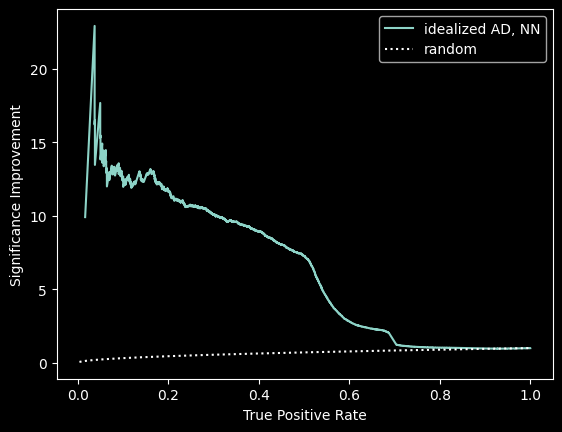

In [9]:
# now let's evaluate the signal extraction performance on the same test set

clsf_test_set = np.vstack([innerdata_test,
                           innerdata_extrabkg_test,
                           innerdata_extrasig_test])

X_test = clsf_test_set[:, 1:-1]
y_test = clsf_test_set[:, -1]

nn_preds_test = nn_full_model.predict(X_test).flatten()

with np.errstate(divide='ignore', invalid='ignore'):
    nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_preds_test)
    nn_bkg_rej = 1 / nn_fpr
    nn_sic = nn_tpr / np.sqrt(nn_fpr)

    random_tpr = np.linspace(0, 1, 300)
    random_bkg_rej = 1 / random_tpr
    random_sic = random_tpr / np.sqrt(random_tpr)

# SIC curve
plt.plot(nn_tpr, nn_sic, label="idealized AD, NN")
plt.plot(random_tpr, random_sic, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()

Now that we reproduced the neural network benchmark on the default four high-level input features of the LHCO data, let's train a Histogram-based Gradient Boosting Classification Tree on the exact same input data. Our implementation here wraps the scikit-learn implementation in a way to have more control over the validation loss and add the same model saving/loading functionality as we have in the neural network.

In [10]:
# either train new HistGradientBoosting classifier to distinguish between "data" and background

# note that the scaler here is the same as we used for the NN
scaler = StandardScaler()
scaler.fit(clsf_train_set[:, 1:-1])

X_train = scaler.transform(clsf_train_set[:, 1:-1])
y_train = clsf_train_set[:, -1]
X_val = scaler.transform(clsf_val_set[:, 1:-1])
y_val = clsf_val_set[:, -1]

bdt_classifier_savedir = "./trained_classifiers_tree_idealized-ad_0/"
# Let's protect ourselves from accidentally overwriting a trained model.
if not exists(join(bdt_classifier_savedir, "CLSF_models")):
    bdt_classifier_model = HGBClassifier(save_path=bdt_classifier_savedir,
                                         early_stopping=True, max_iters=None,
                                         verbose=True)
    bdt_classifier_model.fit(X_train, y_train, X_val, y_val)

    # merge scaler and classifier into a single pipeline
    bdt_full_model = make_pipeline(scaler, bdt_classifier_model)
else:
    print(f"The model exists already in {bdt_classifier_savedir}. Remove first if you want to overwrite.")

training iteration 0...
	train loss: 0.6929962035722679, val loss: 0.6930587993180856
training iteration 1...
	train loss: 0.6928809224646857, val loss: 0.692998686939113
training iteration 2...
	train loss: 0.692749172609213, val loss: 0.692970767221196
training iteration 3...
	train loss: 0.6926401373638803, val loss: 0.6929373091057788
training iteration 4...
	train loss: 0.6925270243057765, val loss: 0.6928764229688686
training iteration 5...
	train loss: 0.6924293361299257, val loss: 0.6928630026619786
training iteration 6...
	train loss: 0.6923283972537309, val loss: 0.6928747296058206
training iteration 7...
	train loss: 0.6922274946466254, val loss: 0.6928250451905839
training iteration 8...
	train loss: 0.6921273372194985, val loss: 0.6928361776071954
training iteration 9...
	train loss: 0.6920409095264953, val loss: 0.6928358095564382
training iteration 10...
	train loss: 0.6919454814883984, val loss: 0.6928391989453805
training iteration 11...
	train loss: 0.6918662818737316

In [11]:
# or alternatively load existing classifer model

scaler = StandardScaler()
scaler.fit(clsf_train_set[:, 1:-1])

bdt_classifier_savedir = "./trained_classifiers_tree_idealized-ad_0/"
bdt_classifier_model = HGBClassifier(save_path=bdt_classifier_savedir,
                                     load=True)
bdt_full_model = make_pipeline(scaler, bdt_classifier_model)

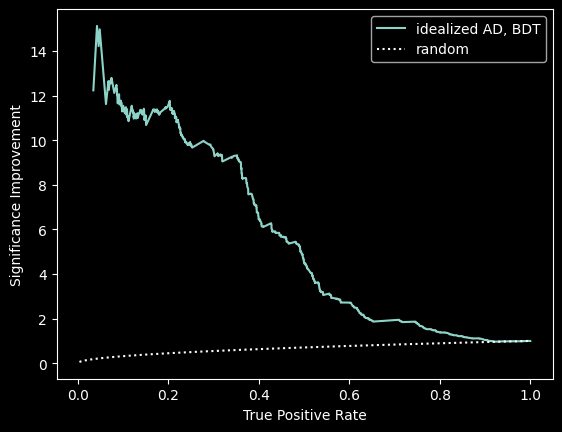

In [12]:
# now let's evaluate the signal extraction performance on the same test set

clsf_test_set = np.vstack([innerdata_test,
                           innerdata_extrabkg_test,
                           innerdata_extrasig_test])

X_test = clsf_test_set[:, 1:-1]
y_test = clsf_test_set[:, -1]

bdt_preds_test = bdt_full_model.predict(X_test).flatten()

with np.errstate(divide='ignore', invalid='ignore'):
    bdt_fpr, bdt_tpr, _ = roc_curve(y_test, bdt_preds_test)
    bdt_bkg_rej = 1 / bdt_fpr
    bdt_sic = bdt_tpr / np.sqrt(bdt_fpr)

    random_tpr = np.linspace(0, 1, 300)
    random_bkg_rej = 1 / random_tpr
    random_sic = random_tpr / np.sqrt(random_tpr)

# SIC curve
plt.plot(bdt_tpr, bdt_sic, label="idealized AD, BDT")
plt.plot(random_tpr, random_sic, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()

The performance in terms of SICs should be roughly the same on these input data. Of course, there is some run-by-run variance, which we could quantify more thoroughly by plotting the median and 68% CL bands, as in the end of `demos/weak_supervision.ipynb`. But for a first check we see that the BDT performs similarly to the NN, while being significantly faster to train.

Now let's put the two models to the test of how they react to uninformative features. We will add ten features of pure Gaussian noise (thus abbreviating to 10G), without any discrimination power between signal and background. Thus, most input dimensions will now be useless for the classification task.

In [13]:
def add_n_noise_features(X, n=10):
    # note that the last column is the signal-vs-background label
    data = X[:, :-1]
    labels = X[:, -1:]
    noise = np.random.normal(size=(X.shape[0], n))
    return np.hstack([data, noise, labels])


# we consistently add the noise to training, validation and test set
innerdata_train_noisy = add_n_noise_features(innerdata_train)
innerdata_val_noisy = add_n_noise_features(innerdata_val)
innerdata_test_noisy = add_n_noise_features(innerdata_test)

innerdata_extrabkg_train_noisy = add_n_noise_features(innerdata_extrabkg_train)
innerdata_extrabkg_val_noisy = add_n_noise_features(innerdata_extrabkg_val)
innerdata_extrabkg_test_noisy = add_n_noise_features(innerdata_extrabkg_test)

innerdata_extrasig_test_noisy = add_n_noise_features(innerdata_extrasig_test)

In [14]:
# assigning label 1 to "data"
clsf_train_data_noisy = innerdata_train_noisy.copy()
clsf_train_data_noisy[:, -1] = np.ones_like(clsf_train_data_noisy[:, -1])
clsf_val_data_noisy = innerdata_val_noisy.copy()
clsf_val_data_noisy[:, -1] = np.ones_like(clsf_val_data_noisy[:, -1])

# and label 0 to background
clsf_train_bkg_noisy = innerdata_extrabkg_train_noisy.copy()
clsf_train_bkg_noisy[:, -1] = np.zeros_like(clsf_train_bkg_noisy[:, -1])
clsf_val_bkg_noisy = innerdata_extrabkg_val_noisy.copy()
clsf_val_bkg_noisy[:, -1] = np.zeros_like(clsf_val_bkg_noisy[:, -1])

# mixing together and shuffling
clsf_train_set_noisy = np.vstack([clsf_train_data_noisy, clsf_train_bkg_noisy])
clsf_val_set_noisy = np.vstack([clsf_val_data_noisy, clsf_val_bkg_noisy])
clsf_train_set_noisy = shuffle(clsf_train_set_noisy, random_state=42)
clsf_val_set_noisy = shuffle(clsf_val_set_noisy, random_state=42)

In [15]:
# either train new NN classifier

scaler_noisy = StandardScaler()
scaler_noisy.fit(clsf_train_set_noisy[:, 1:-1])

X_train = scaler_noisy.transform(clsf_train_set_noisy[:, 1:-1])
y_train = clsf_train_set_noisy[:, -1]
X_val = scaler_noisy.transform(clsf_val_set_noisy[:, 1:-1])
y_val = clsf_val_set_noisy[:, -1]

nn_classifier_savedir_noisy = "./trained_classifiers_idealized-ad_10G_0/"
# Let's protect ourselves from accidentally overwriting a trained model.
if not exists(join(nn_classifier_savedir_noisy, "CLSF_models")):
    nn_classifier_model_noisy = NeuralNetworkClassifier(save_path=nn_classifier_savedir_noisy,
                                                        n_inputs=X_train.shape[1],
                                                        early_stopping=True, epochs=None,
                                                        verbose=True)
    nn_classifier_model_noisy.fit(X_train, y_train, X_val, y_val)

    # merge scaler and classifier into a single pipeline
    nn_full_model_noisy = make_pipeline(scaler_noisy, nn_classifier_model_noisy)
else:
    print(f"The model exists already in {nn_classifier_savedir_noisy}. Remove first if you want to overwrite.")


Epoch: 0


Train loss: 0.693261: 100%|██████████| 261375/261375 [00:05<00:00, 46905.69it/s]


Validation loss: 0.6931148415979217

Epoch: 1


Train loss: 0.693116: 100%|██████████| 261375/261375 [00:05<00:00, 47502.46it/s]


Validation loss: 0.6930867018945077

Epoch: 2


Train loss: 0.693063: 100%|██████████| 261375/261375 [00:05<00:00, 48676.39it/s]


Validation loss: 0.6931972038219957

Epoch: 3


Train loss: 0.692940: 100%|██████████| 261375/261375 [00:05<00:00, 49865.25it/s]


Validation loss: 0.6929544648703407

Epoch: 4


Train loss: 0.692784: 100%|██████████| 261375/261375 [00:05<00:00, 48580.40it/s]


Validation loss: 0.6930186857195462

Epoch: 5


Train loss: 0.692561: 100%|██████████| 261375/261375 [00:05<00:00, 52084.95it/s]


Validation loss: 0.6936627623789451

Epoch: 6


Train loss: 0.692305: 100%|██████████| 261375/261375 [00:04<00:00, 57712.46it/s]


Validation loss: 0.6938344684593818

Epoch: 7


Train loss: 0.691884: 100%|██████████| 261375/261375 [00:05<00:00, 52224.44it/s]


Validation loss: 0.6941516580827096

Epoch: 8


Train loss: 0.691479: 100%|██████████| 261375/261375 [00:04<00:00, 54235.16it/s]


Validation loss: 0.6942660876933267

Epoch: 9


Train loss: 0.691047: 100%|██████████| 261375/261375 [00:04<00:00, 54020.30it/s]


Validation loss: 0.6948454350233078

Epoch: 10


Train loss: 0.690536: 100%|██████████| 261375/261375 [00:05<00:00, 52271.61it/s]


Validation loss: 0.6951066550086527

Epoch: 11


Train loss: 0.689817: 100%|██████████| 261375/261375 [00:04<00:00, 53888.15it/s]


Validation loss: 0.6951975405216217

Epoch: 12


Train loss: 0.689389: 100%|██████████| 261375/261375 [00:05<00:00, 49883.01it/s]


Validation loss: 0.6958049192148097

Epoch: 13


Train loss: 0.688739: 100%|██████████| 261375/261375 [00:05<00:00, 51918.90it/s]


Validation loss: 0.6958268462735064
Early stopping at epoch 13
Loading best model state...


In [16]:
# or alternatively load existing classifer model

scaler_noisy = StandardScaler()
scaler_noisy.fit(clsf_train_set_noisy[:, 1:-1])

nn_classifier_savedir_noisy = "./trained_classifiers_idealized-ad_10G_0/"
nn_classifier_model_noisy = NeuralNetworkClassifier(save_path=nn_classifier_savedir_noisy,
                                                    n_inputs=clsf_train_set_noisy[:, 1:-1].shape[1],
                                                    load=True)
nn_full_model_noisy = make_pipeline(scaler_noisy, nn_classifier_model_noisy)

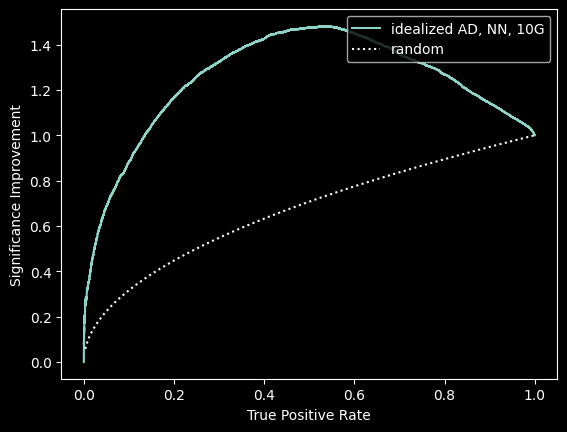

In [17]:
# now let's evaluate the signal extraction performance on the same test set

clsf_test_set_noisy = np.vstack([innerdata_test_noisy,
                           innerdata_extrabkg_test_noisy,
                           innerdata_extrasig_test_noisy])

X_test_noisy = clsf_test_set_noisy[:, 1:-1]
y_test_noisy = clsf_test_set_noisy[:, -1]

nn_preds_test_noisy = nn_full_model_noisy.predict(X_test_noisy).flatten()

with np.errstate(divide='ignore', invalid='ignore'):
    nn_fpr_noisy, nn_tpr_noisy, _ = roc_curve(y_test_noisy, nn_preds_test_noisy)
    nn_bkg_rej_noisy = 1 / nn_fpr_noisy
    nn_sic_noisy = nn_tpr_noisy / np.sqrt(nn_fpr_noisy)

    random_tpr = np.linspace(0, 1, 300)
    random_bkg_rej = 1 / random_tpr
    random_sic = random_tpr / np.sqrt(random_tpr)

# SIC curve
plt.plot(nn_tpr_noisy, nn_sic_noisy, label="idealized AD, NN, 10G")
plt.plot(random_tpr, random_sic, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()

The neural network reacts poorly to this change, with only a fraction of the previous SIC left :(

In [18]:
# either train new BDT classifier

scaler_noisy = StandardScaler()
scaler_noisy.fit(clsf_train_set_noisy[:, 1:-1])

X_train = scaler_noisy.transform(clsf_train_set_noisy[:, 1:-1])
y_train = clsf_train_set_noisy[:, -1]
X_val = scaler_noisy.transform(clsf_val_set_noisy[:, 1:-1])
y_val = clsf_val_set_noisy[:, -1]

bdt_classifier_savedir_noisy = "./trained_classifiers_tree_idealized-ad_10G_0/"
# Let's protect ourselves from accidentally overwriting a trained model.
if not exists(join(bdt_classifier_savedir_noisy, "CLSF_models")):
    bdt_classifier_model_noisy = HGBClassifier(save_path=bdt_classifier_savedir_noisy,
                                               early_stopping=True, max_iters=None,
                                               verbose=True)
    bdt_classifier_model_noisy.fit(X_train, y_train, X_val, y_val)

    # merge scaler and classifier into a single pipeline
    bdt_full_model_noisy = make_pipeline(scaler_noisy, bdt_classifier_model_noisy)
else:
    print(f"The model exists already in {bdt_classifier_savedir_noisy}. Remove first if you want to overwrite.")

training iteration 0...
	train loss: 0.6929668111459667, val loss: 0.6930791534305663
training iteration 1...
	train loss: 0.6928073466919901, val loss: 0.6930273428395993
training iteration 2...
	train loss: 0.6926820259166547, val loss: 0.6930161420396979
training iteration 3...
	train loss: 0.6925158021001304, val loss: 0.6929809384179327
training iteration 4...
	train loss: 0.6923631846358012, val loss: 0.6929280175383585
training iteration 5...
	train loss: 0.6922495418434412, val loss: 0.6929337808892934
training iteration 6...
	train loss: 0.6921061926528047, val loss: 0.6929084366368226
training iteration 7...
	train loss: 0.6919680389565037, val loss: 0.6929105380373454
training iteration 8...
	train loss: 0.6918311423402431, val loss: 0.6929000717131094
training iteration 9...
	train loss: 0.6917093493032999, val loss: 0.6929150733029761
training iteration 10...
	train loss: 0.691574943208679, val loss: 0.6929181355940311
training iteration 11...
	train loss: 0.69146309036749

In [19]:
# or alternatively load existing classifer model

scaler_noisy = StandardScaler()
scaler_noisy.fit(clsf_train_set_noisy[:, 1:-1])

bdt_classifier_savedir_noisy = "./trained_classifiers_tree_idealized-ad_10G_0/"
bdt_classifier_model_noisy = HGBClassifier(save_path=bdt_classifier_savedir_noisy,
                                           load=True)
bdt_full_model_noisy = make_pipeline(scaler_noisy, bdt_classifier_model_noisy)

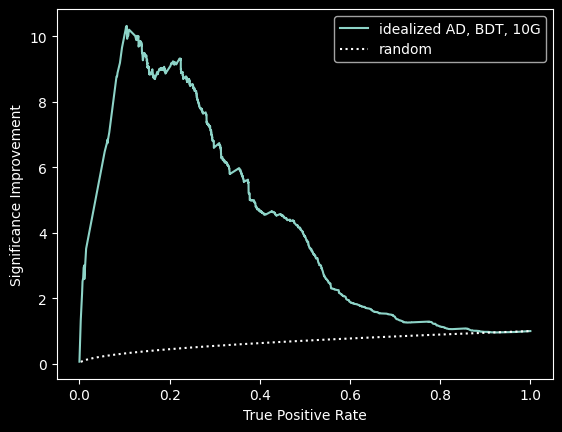

In [20]:
# now let's evaluate the signal extraction performance on the same test set

clsf_test_set_noisy = np.vstack([innerdata_test_noisy,
                                 innerdata_extrabkg_test_noisy,
                                 innerdata_extrasig_test_noisy])

X_test_noisy = clsf_test_set_noisy[:, 1:-1]
y_test_noisy = clsf_test_set_noisy[:, -1]

bdt_preds_test_noisy = bdt_full_model_noisy.predict(X_test_noisy).flatten()

with np.errstate(divide='ignore', invalid='ignore'):
    bdt_fpr_noisy, bdt_tpr_noisy, _ = roc_curve(y_test_noisy, bdt_preds_test_noisy)
    bdt_bkg_rej_noisy = 1 / bdt_fpr_noisy
    bdt_sic_noisy = bdt_tpr_noisy / np.sqrt(bdt_fpr_noisy)

    random_tpr = np.linspace(0, 1, 300)
    random_bkg_rej = 1 / random_tpr
    random_sic = random_tpr / np.sqrt(random_tpr)

# SIC curve
plt.plot(bdt_tpr_noisy, bdt_sic_noisy, label="idealized AD, BDT, 10G")
plt.plot(random_tpr, random_sic, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()

There is likely also a drop in performance in the BDT, compared to before, but the remaining SIC is substantially higher than the NN case. Plus, it was much faster to train.

But to get more out of the BDT, we should train an ensemble of multiple BDTs, each with a different separation into training and validation data. Since BDTs train so fast, this is not really a problem. We use an ensemble of ten models here for illustration, but we could do even better with larger ensembles.

We conveniently implement the model here with a wrapper class `EnsembleModel`, which has the same API as a single model and takes care of the averaging of provided models under the hood.

In [21]:
# mix together train and validation set for different splits
innerdata_train_val_noisy = np.vstack([innerdata_train_noisy,
                                       innerdata_val_noisy])
innerdata_extrabkg_train_val_noisy = np.vstack([innerdata_extrabkg_train_noisy,
                                                innerdata_extrabkg_val_noisy])

In [22]:
# train ensemble of trees with different train/val splits
n_classifiers = 10

model_noisy_list = []
for i in range(n_classifiers):

    # different split per classifier
    # (could also do this more controlled via a fixed k-folding scheme)
    _innerdata_train, _innerdata_val = train_test_split(
        innerdata_train_val_noisy, train_size=0.8, random_state=1337+i)
    _innerdata_extrabkg_train, _innerdata_extrabkg_val = train_test_split(
        innerdata_extrabkg_train_val_noisy, train_size=0.8, random_state=1337+i)

    # assigning label 1 to "data"
    _clsf_train_data = _innerdata_train
    _clsf_train_data[:, -1] = np.ones_like(_clsf_train_data[:, -1])
    _clsf_val_data = _innerdata_val
    _clsf_val_data[:, -1] = np.ones_like(_clsf_val_data[:, -1])

    # and label 0 to background
    _clsf_train_bkg = _innerdata_extrabkg_train
    _clsf_train_bkg[:, -1] = np.zeros_like(_clsf_train_bkg[:, -1])
    _clsf_val_bkg = _innerdata_extrabkg_val
    _clsf_val_bkg[:, -1] = np.zeros_like(_clsf_val_bkg[:, -1])

    # mixing together and shuffling
    _clsf_train_set = np.vstack([_clsf_train_data, _clsf_train_bkg])
    _clsf_val_set = np.vstack([_clsf_val_data, _clsf_val_bkg])
    _clsf_train_set = shuffle(_clsf_train_set, random_state=42)
    _clsf_val_set = shuffle(_clsf_val_set, random_state=42)

    # fit scaler
    _scaler = StandardScaler()
    _scaler.fit(_clsf_train_set[:, 1:-1])

    # train classifier
    _classifier_savedir = f"./trained_classifier_idealized-ad_ensemble_10G/model_{i}/"
    _classifier = HGBClassifier(save_path=_classifier_savedir,
                                early_stopping=True, max_iters=None,
                                verbose=False)

    # We don't want to overwrite the model if it already exists.
    if not exists(join(_classifier_savedir, "CLSF_models")):
        X_train = _scaler.transform(_clsf_train_set[:, 1:-1])
        y_train = _clsf_train_set[:, -1]
        X_val = _scaler.transform(_clsf_val_set[:, 1:-1])
        y_val = _clsf_val_set[:, -1]
        _classifier.fit(X_train, y_train, X_val, y_val)
    else:
        print(f"The model exists already in {_classifier_savedir}. Remove first if you want to overwrite. Loading its best state now.")
        _classifier.load_best_model()

    # merge scaler and classifier into a single pipeline model
    _pipeline = make_pipeline(_scaler, _classifier)
    model_noisy_list.append(_pipeline)

# Now merging all these models into a single ensemble model
ensemble_noisy = EnsembleModel(model_noisy_list)

Early stopping at iteration 13
Loading best model state...
Early stopping at iteration 12
Loading best model state...
Early stopping at iteration 14
Loading best model state...
Early stopping at iteration 22
Loading best model state...
Early stopping at iteration 20
Loading best model state...
Early stopping at iteration 13
Loading best model state...
Early stopping at iteration 11
Loading best model state...
Early stopping at iteration 14
Loading best model state...
Early stopping at iteration 16
Loading best model state...
Early stopping at iteration 11
Loading best model state...


In [ ]:
# now let's evaluate the signal extraction performance on the same test set

clsf_test_set_noisy = np.vstack([innerdata_test_noisy,
                                 innerdata_extrabkg_test_noisy,
                                 innerdata_extrasig_test_noisy])

X_test_noisy = clsf_test_set_noisy[:, 1:-1]
y_test_noisy = clsf_test_set_noisy[:, -1]

ensemble_preds_test_noisy = ensemble_noisy.predict(X_test_noisy).flatten()

with np.errstate(divide='ignore', invalid='ignore'):
    ensemble_fpr_noisy, ensemble_tpr_noisy, _ = roc_curve(y_test_noisy, ensemble_preds_test_noisy)
    ensemble_bkg_rej_noisy = 1 / ensemble_fpr_noisy
    ensemble_sic_noisy = ensemble_tpr_noisy / np.sqrt(ensemble_fpr_noisy)

    random_tpr = np.linspace(0, 1, 300)
    random_bkg_rej = 1 / random_tpr
    random_sic = random_tpr / np.sqrt(random_tpr)

# SIC curve
plt.plot(ensemble_tpr_noisy, ensemble_sic_noisy, label="idealized AD, BDT ensemble, 10G")
plt.plot(random_tpr, random_sic, "w:", label="random")
plt.xlabel("True Positive Rate")
plt.ylabel("Significance Improvement")
plt.legend(loc="upper right")
plt.show()

We should see another substantial improvement compared to the single tree model. In fact, the performance of an ensemble model tends to be higher than the performance of each individual model that go into the ensemble, i.e. it's not just trivially averaging out the run-by-run variance. A way to understand this is that a single event might get a high (close to 1) prediction by one model but background-like (close to 0.5) prediction by the others. The average of these predictions is still shifted upwards compared to the case where all models agree on a background-like prediction. NNs can also benefit from this type of ensembling, but in this case it will not be sufficient to recover the performance drop due to the noise, plus their longer training times makes ensembling less cheap.

In summary, we have now seen that BDTs are a nice alternative to neural networks in weakly supervised anomaly detection for two reasons:

1) they are more resilient to uninformative input features
2) they are much faster to train

The latter point makes it very attractive to squeeze out more performance by ensembling over many individually trained BDTs (which are technically also making use of ensembling under the hood individually).